In [1]:
# Import libraries
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
%matplotlib inline
import quantstats as qs
plt.style.use('fivethirtyeight')

In [3]:
msft = yf.download('MSFT' , start='2018-01-01', end='2023-11-25')

[*********************100%%**********************]  1 of 1 completed


In [4]:
msft

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,80.229012,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,80.602386,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,81.311798,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,82.319885,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,82.403915,22113000
...,...,...,...,...,...,...
2023-11-17,373.609985,374.369995,367.000000,369.850006,369.850006,40157000
2023-11-20,371.220001,378.869995,371.000000,377.440002,377.440002,52465100
2023-11-21,375.670013,376.220001,371.119995,373.070007,373.070007,28423100


Text(0.5, 1.0, 'MSFT Price vs Time')

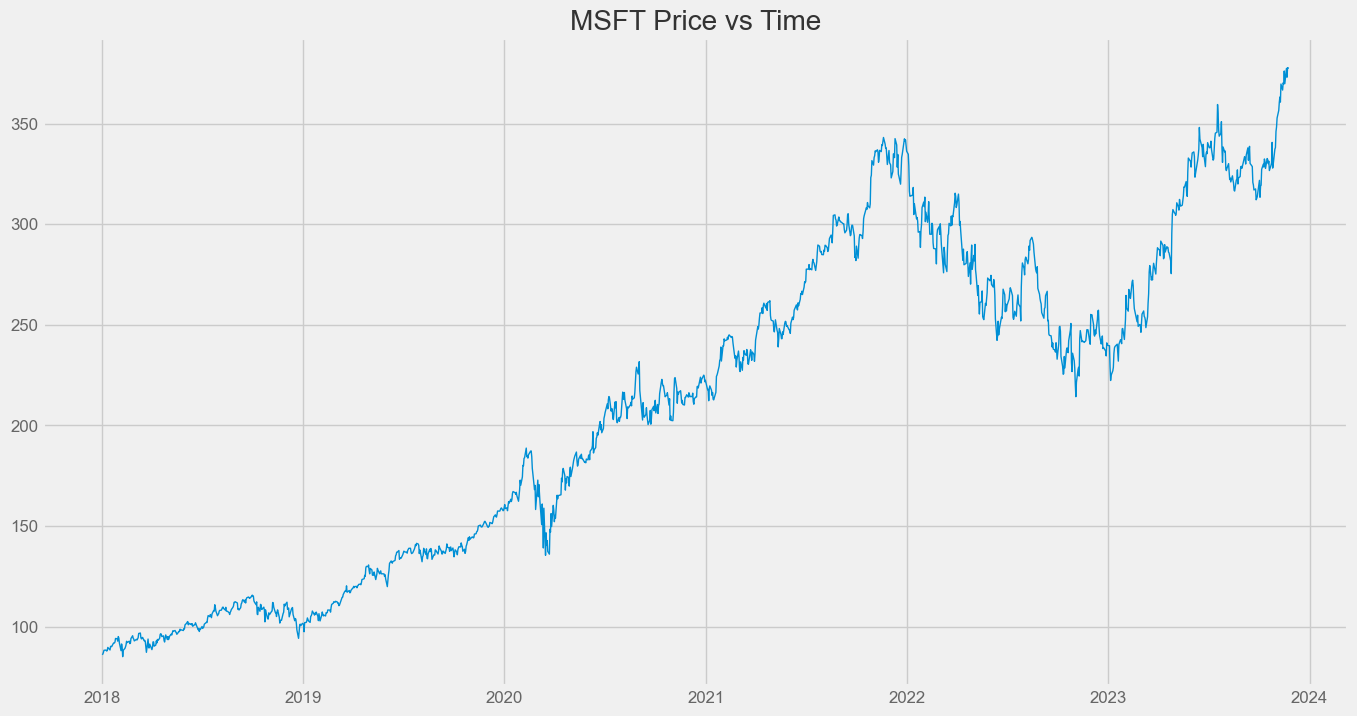

In [5]:
plt.figure(figsize=(15,8))
plt.plot(msft['Close'], linewidth=1)
plt.title('MSFT Price vs Time')


In [8]:
#create required data fields for backtesting.

def stochastic_oscillator(data,stock, price_window , smoothing_window): 
    
    data['L14'] = stock['Low'].rolling(window=price_window).min()
    data['H14'] = stock['High'].rolling(window=price_window).max()
    data['%k']  = (data['Close']-data['L14'])/(data['H14']-data['L14'])*100
    data['slow_indicator'] = data['%k'].rolling(window = smoothing_window).mean()
    print(data)
    
data = msft[['Close']]
stochastic_oscillator(data, stock=msft, price_window=14, smoothing_window=3)    


                 Close         L14         H14         %k  slow_indicator
Date                                                                     
2018-01-02   85.949997         NaN         NaN        NaN             NaN
2018-01-03   86.349998         NaN         NaN        NaN             NaN
2018-01-04   87.110001         NaN         NaN        NaN             NaN
2018-01-05   88.190002         NaN         NaN        NaN             NaN
2018-01-08   88.279999         NaN         NaN        NaN             NaN
...                ...         ...         ...        ...             ...
2023-11-17  369.850006  334.690002  376.350006  84.397505       92.085976
2023-11-20  377.440002  339.649994  378.869995  96.353920       93.449043
2023-11-21  373.070007  344.769989  378.869995  82.991241       87.914222
2023-11-22  377.850006  347.329987  379.790009  94.023410       91.122857
2023-11-24  377.429993  353.350006  379.790009  91.074071       89.362907

[1485 rows x 5 columns]


C:\Users\akarte\AppData\Local\Temp\ipykernel_3840\2597134604.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['L14'] = stock['Low'].rolling(window=price_window).min()
C:\Users\akarte\AppData\Local\Temp\ipykernel_3840\2597134604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['H14'] = stock['High'].rolling(window=price_window).max()
C:\Users\akarte\AppData\Local\Temp\ipykernel_3840\2597134604.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [70]:
#when I buy I buy in fractions. so my liquidity=0 after buying
def signal(data):
    buy_signal = []              #stores price when buy signal was given
    sell_signal = []             #stores price when sell signal was given
    trading_capital = 100000              # our initial capital available to trade. When we buy we lose all trading_capital. And when we sell we gain trading capital
    open_position_qty = []       #stores qty of shares that we are currently holding on any given day
    open_position_value = [] #how much is our portfolio valued at 
    qty = 0  #keeps record of our position(qty in trade) if=0 means nothing purchased yet. if>0 means we already have a some shares or we did a buy trade previously
    trade = [] #stores our decision 1=buy, 0=sell, nan = d0 nothing
    fund_value = []
    liquidity = []
    cost = []
    cost_assumption = 0.03
    
    for i in range(len(data)):
        price = data['Close'][i]
    
        if data['slow_indicator'][i]>80 and data['%k'][i]>data['slow_indicator'][i]: #buy signal
            if qty == 0:  #buy signal and I have no shares. 
                trade.append(1)
                qty = trading_capital/price
                open_position_qty.append(qty)
                trading_capital = 0
                open_position_value.append(price*qty)
                buy_signal.append(price)
                sell_signal.append(np.NAN) 
                fund_value.append(price*qty)
                liquidity.append(trading_capital)
                cost.append(cost_assumption*price)
            else: #buy signal but I already have shares. 
                trade.append(np.NAN)
                open_position_qty.append(qty)
                trading_capital = 0
                open_position_value.append(price*qty)
                buy_signal.append(price)
                sell_signal.append(np.NaN)
                fund_value.append(price*qty)
                liquidity.append(trading_capital)
                cost.append(np.NAN)
                

        elif data['slow_indicator'][i]<20 and data['%k'][i]<data['slow_indicator'][i]: #sell signal
            if qty>0: #sell signal and I have some shares to sell
                trade.append(0)
                trading_capital = qty*price
                qty=0
                open_position_qty.append(qty)
                open_position_value.append(price*qty)
                sell_signal.append(price)
                buy_signal.append(np.NaN)
                fund_value.append(trading_capital)
                liquidity.append(trading_capital)
                cost.append(cost_assumption*price)
            else: #sell signal and I have no shares to sell
                trade.append(np.NAN)
                open_position_qty.append(qty)
                open_position_value.append(price*qty)
                sell_signal.append(price)
                buy_signal.append(np.NaN)
                fund_value.append(trading_capital)
                liquidity.append(trading_capital)
                cost.append(np.NAN)
        
        else:   
            trade.append(np.NaN)
            sell_signal.append(np.NaN)
            buy_signal.append(np.NaN)
            cost.append(np.NAN)
            if qty>0:
                    open_position_qty.append(qty)
                    open_position_value.append(qty*price)
                    fund_value.append(qty*price)
                    liquidity.append(trading_capital)
            else:
                    open_position_qty.append(0)
                    open_position_value.append(0)
                    fund_value.append(trading_capital)
                    liquidity.append(trading_capital)

        
    return qty, trading_capital, trade, buy_signal , sell_signal, open_position_qty, open_position_value, fund_value, liquidity,cost

            


    

In [72]:
qty, trading_capital, trade, buy_signal , sell_signal, open_position_qty, open_position_value, fund_value, liquidity, cost = signal(data)

In [73]:
print(qty, trading_capital)

454.892045028735 0


This implies I am holding stocks at the end of my backtesting period

In [74]:
results = pd.DataFrame({'trade':trade,
                        'buy_signal':buy_signal,
                        'sell_signal':sell_signal,
                        'open_postition_qty':open_position_qty,
                        'open_position_value': open_position_value,
                        'fund_value': fund_value,
                        'liquidity':liquidity,
                        'cost' : cost
                      }, index = data.index)


In [75]:
backtest = pd.merge(data,results, on='Date',how='left')
backtest

,Close,L14,H14,%k,slow_indicator,trade,buy_signal,sell_signal,open_postition_qty,open_position_value,fund_value,liquidity,cost
Date,,,,,,,,,,,,,
2018-01-02,85.949997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,100000.000000,100000.0,NaN
2018-01-03,86.349998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,100000.000000,100000.0,NaN
2018-01-04,87.110001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,100000.000000,100000.0,NaN
2018-01-05,88.190002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,100000.000000,100000.0,NaN
2018-01-08,88.279999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,100000.000000,100000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,369.850006,334.690002,376.350006,84.397505,92.085976,NaN,NaN,NaN,454.892045,168241.825630,168241.825630,0.0,NaN
2023-11-20,377.440002,339.649994,378.869995,96.353920,93.449043,NaN,377.440002,NaN,454.892045,171694.454586,171694.454586,0.0,NaN
2023-11-21,373.070007,344.769989,378.869995,82.991241,87.914222,NaN,NaN,NaN,454.892045,169706.578571,169706.578571,0.0,NaN


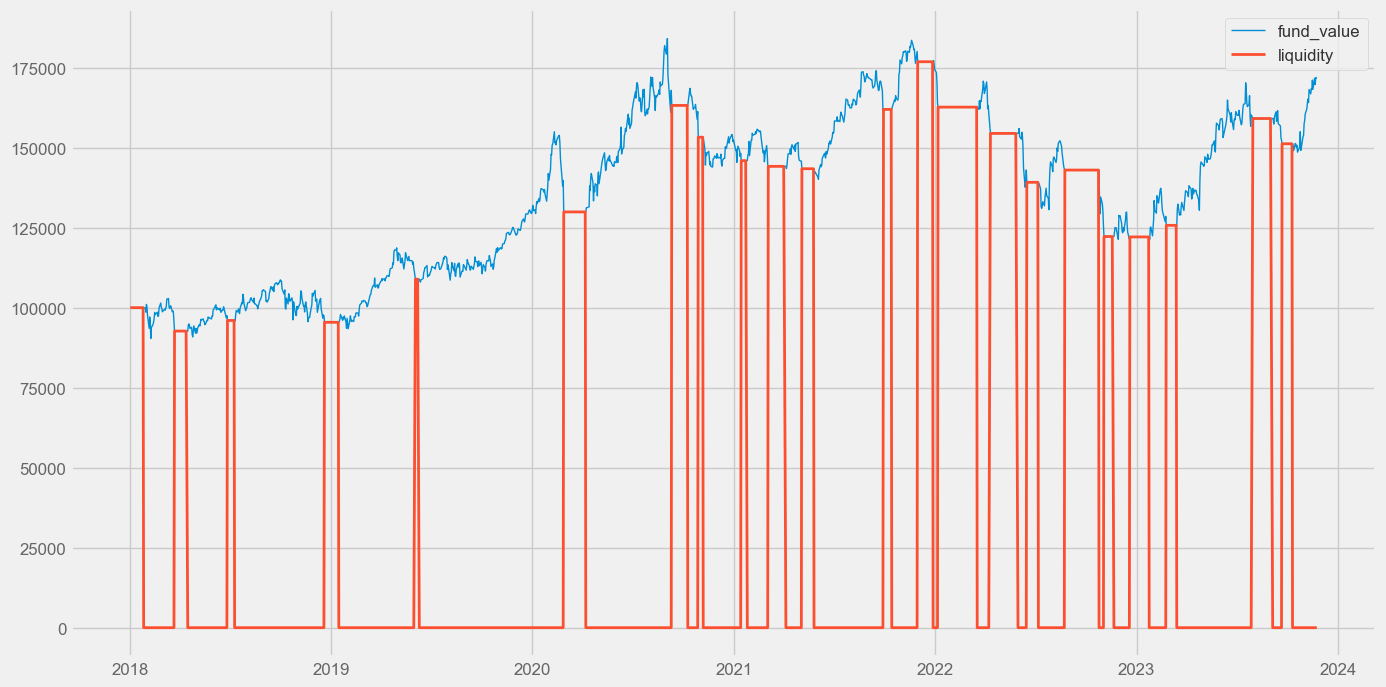

In [76]:
plt.figure(figsize=(15,8))
plt.plot(backtest['fund_value'], linewidth =1, label = 'fund_value')
plt.plot(backtest['liquidity'], linewidth = 2, label= 'liquidity')
plt.legend()

$100,000 invested using this strategy for 5 years would have become $ 171689.9


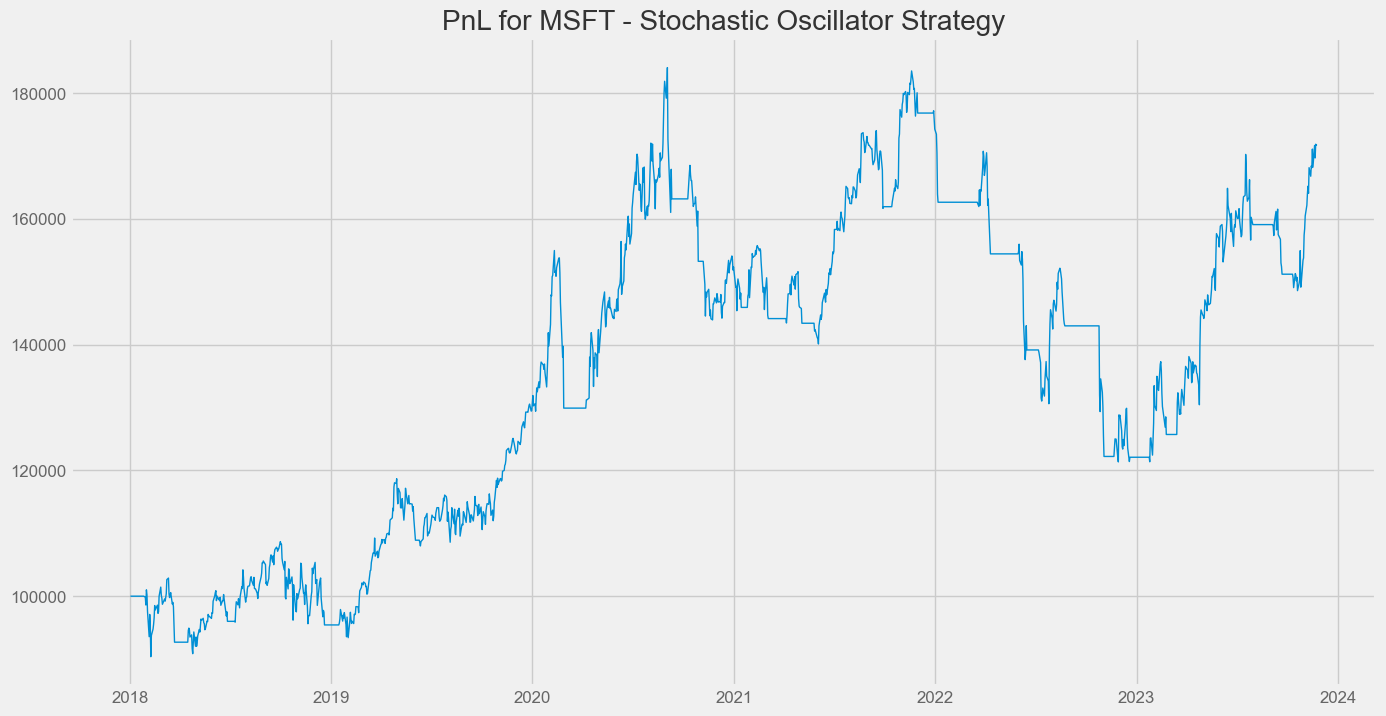

In [77]:
print('$100,000 invested using this strategy for 5 years would have become $', str(round(backtest['fund_value'][-1],2)))
plt.figure(figsize=(15,8))
plt.title("PnL for MSFT - Stochastic Oscillator Strategy")
plt.plot(backtest['fund_value'], linewidth =1)
plt.show()

## USD 100,000 invested using this strategy for 5 years would have become USD 171,689.90

### Lets not forget transaction costs. To proceed I have taken an assumption( while backtesting) of 0.3% per trade since we are dealing in equities.

In [82]:
backtest['fund_value'][-1]

171689.90122346662

In [85]:
#final profit
print("Final fund value after 5 years would be:", round(backtest['fund_value'][-1] - backtest['cost'].sum(),2) )

Final fund value after 5 years would be: 171396.97


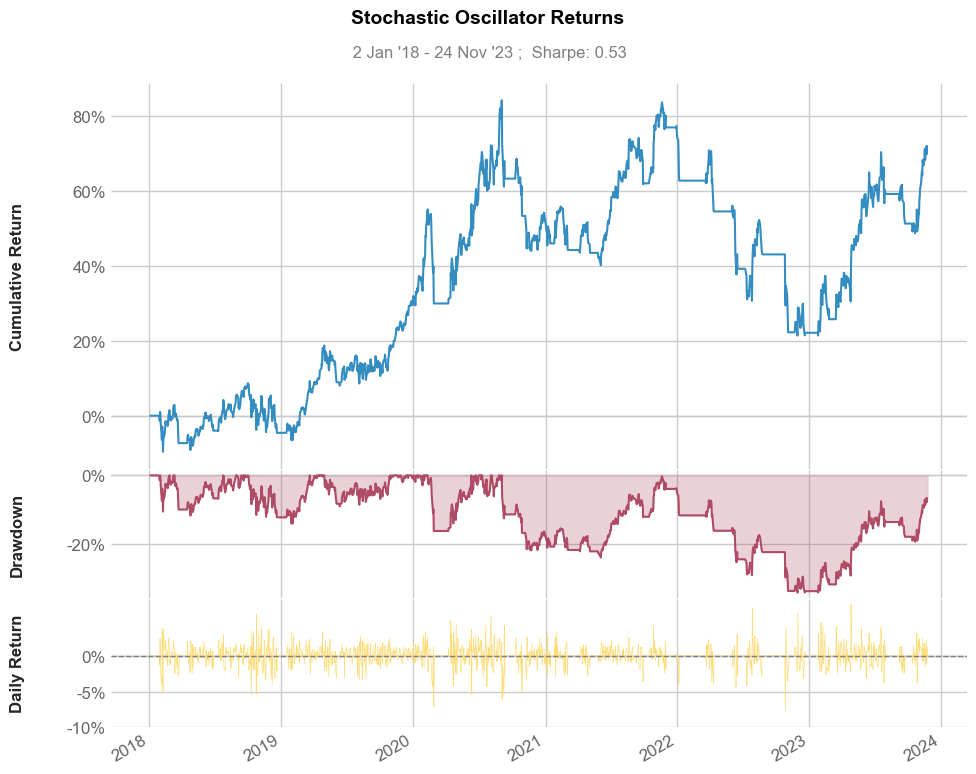

In [86]:
qs.plots.snapshot(backtest['fund_value'].pct_change(), title='Stochastic Oscillator Returns', show=True)

                           Strategy
-------------------------  ----------
Start Period               2018-01-03
End Period                 2023-11-24
Risk-Free Rate             0.0%
Time in Market             72.0%

Cumulative Return          71.69%
CAGR﹪                     6.54%

Sharpe                     0.53
Prob. Sharpe Ratio         89.98%
Smart Sharpe               0.5
Sortino                    0.75
Smart Sortino              0.71
Sortino/√2                 0.53
Smart Sortino/√2           0.5
Omega                      1.11

Max Drawdown               -34.07%
Longest DD Days            1178
Volatility (ann.)          21.84%
Calmar                     0.19
Skew                       -0.19
Kurtosis                   4.25

Expected Daily %           0.04%
Expected Monthly %         0.76%
Expected Yearly %          9.43%
Kelly Criterion            5.45%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.22%
Expected Shortfall (cVaR)  -2.22%

Max Consecutive Wins       9

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-09-03,2022-11-29,2023-11-24,1178,-34.072053,-33.600218
2,2020-02-11,2020-02-27,2020-06-09,120,-16.173823,-15.332947
3,2018-10-02,2019-02-01,2019-03-20,170,-14.060787,-12.681142
4,2018-03-13,2018-04-25,2018-07-24,134,-11.689505,-10.914595
5,2018-02-01,2018-02-08,2018-02-23,23,-10.525208,-7.378173


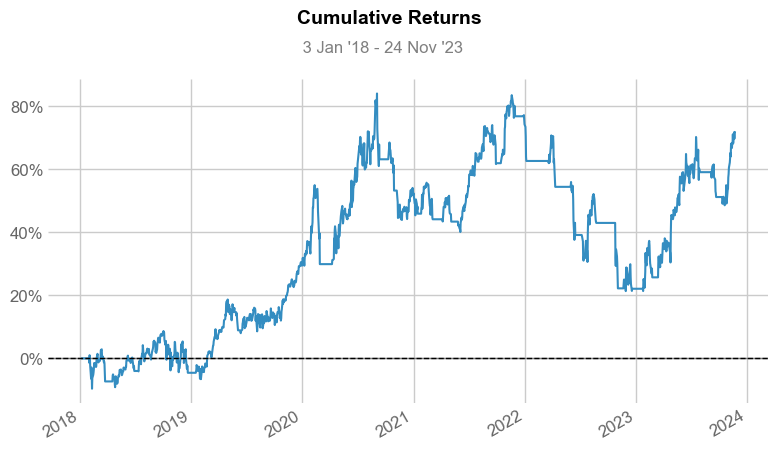

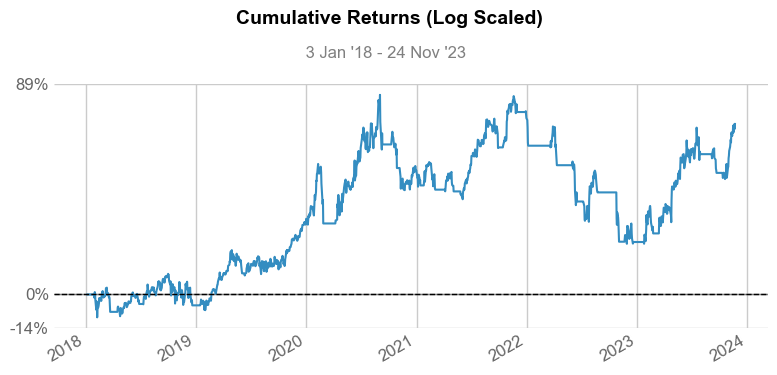

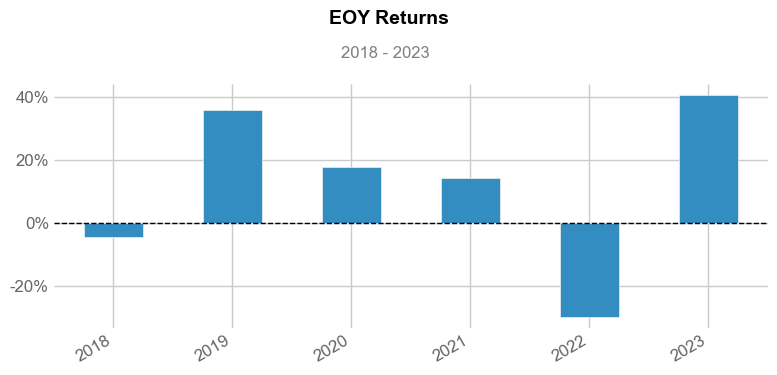

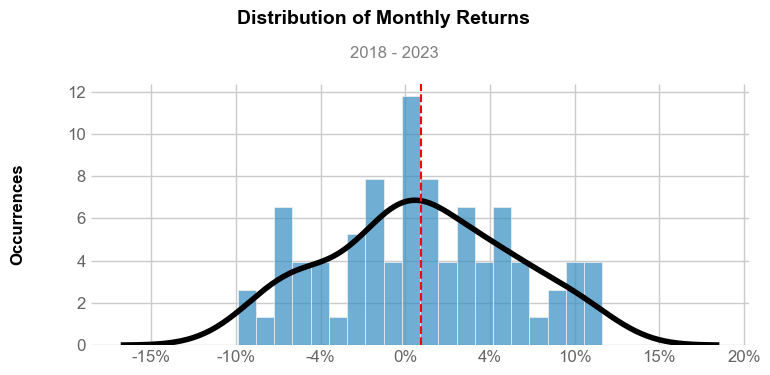

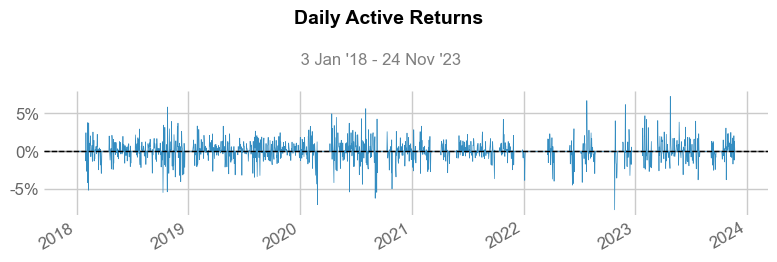

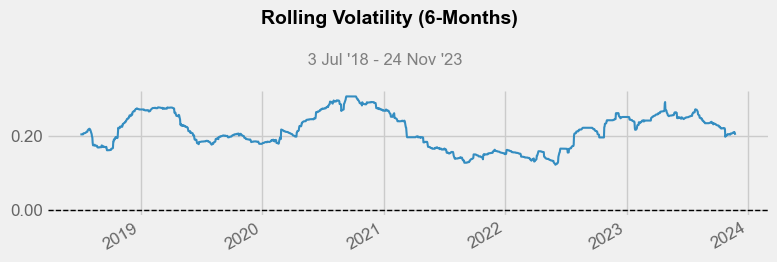

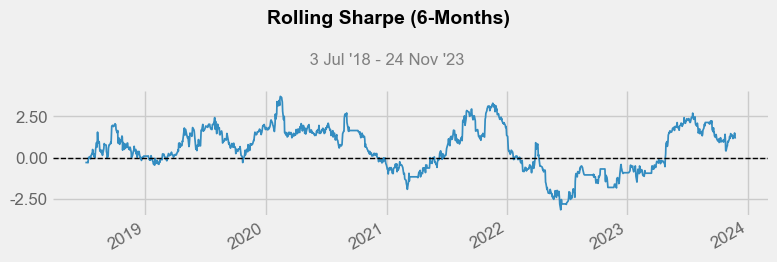

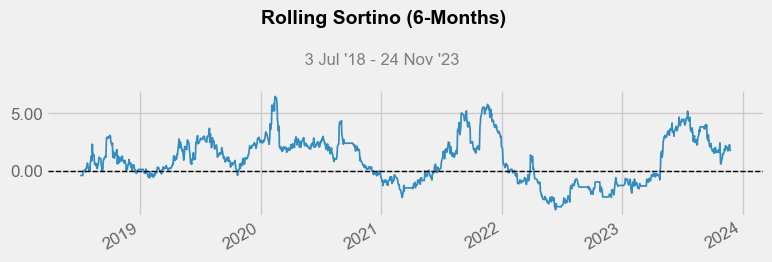

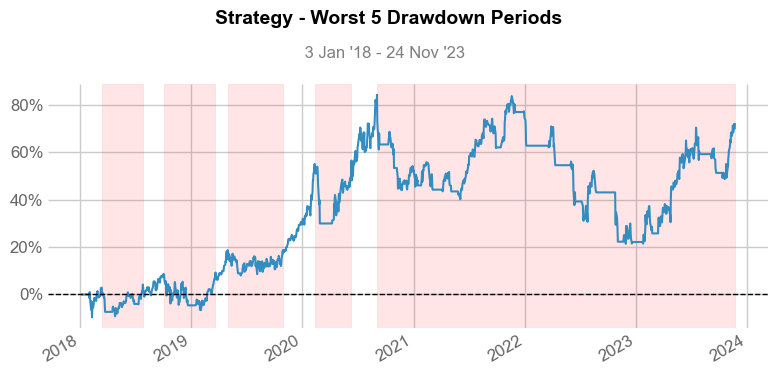

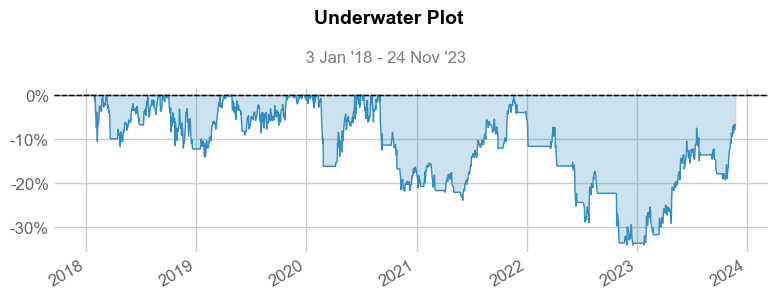

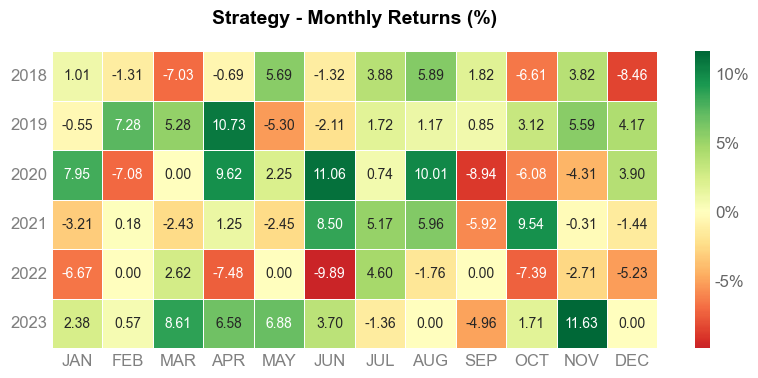

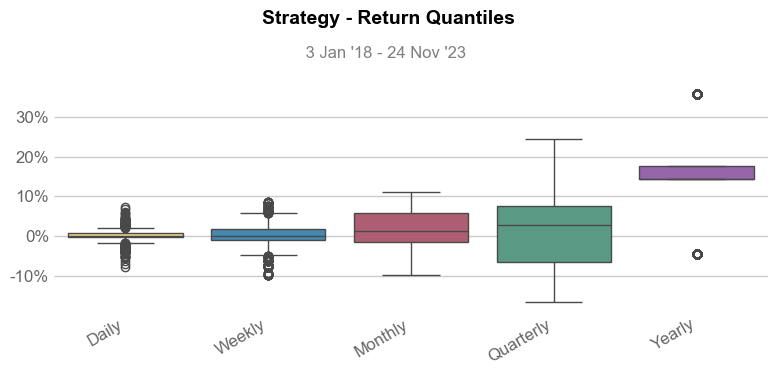

In [87]:

qs.reports.full(backtest['fund_value'].pct_change())